In [1]:
from model.unet import *
from utils.metrics import *
from utils.losses import *
from utils.training import save_checkpoint, load_checkpoint

import os
import pandas as pd
import warnings
import numpy as np
from skimage import io
from rasterio.features import rasterize
from shapely.ops import unary_union
from shapely.geometry import Polygon
from shapely.errors import ShapelyDeprecationWarning
from torch.utils.data import Dataset
import albumentations as A
import torch
from torch.optim import lr_scheduler
import copy
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.cuda import amp
from time import time
import glob
import pickle
from pyproj import Transformer
from shapely.ops import transform as shapely_transform
from rasterio.transform import from_origin
from dotenv import load_dotenv
from datetime import datetime

from pathlib import Path
from sklearn.metrics import jaccard_score, classification_report, confusion_matrix


warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore")

/Users/ix20088/.pyenv/versions/3.8.20/envs/forestchat/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
%load_ext dotenv
%dotenv -o

In [3]:
BASE_DIR = os.environ.get("BASE_DIR", "CAM-ForestNetDataset")
SUB_DIR = os.environ.get("SUB_DIR", "Landsat-Detailed-Timeseries")
PIXEL_RESOLUTION = int(os.environ.get("PIXEL_RESOLUTION", 15))
MODEL_NAME = os.environ.get("MODEL_NAME", "UNET")
TIMESERIES_LENGTH =int(os.environ.get("TIMESERIES_LENGTH", 5))
EXAMPLES_FOLDER = os.environ.get("EXAMPLES_FOLDER", "examples")

train_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/train.csv')
val_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/val.csv')
test_df = pd.read_csv(f'{BASE_DIR}/{SUB_DIR}/test.csv')

train_df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Other large-scale plantations,Other large-scale plantations,4.190500,9.336000,2015,examples/9.336000000000002_4.190500000000001
1,Oil palm plantation,Oil palm plantation,3.899958,9.816542,2015,examples/9.81654166666667_3.8999583333333336
2,Fruit plantation,Fruit plantation,4.729375,9.667375,2015,examples/9.667375_4.729374999999999
3,Rubber plantation,Rubber plantation,4.389250,9.574125,2015,examples/9.574125_4.38925
4,Oil palm plantation,Oil palm plantation,4.254917,8.966458,2015,examples/8.966458333333334_4.2549166666666665


(1, 332, 332)


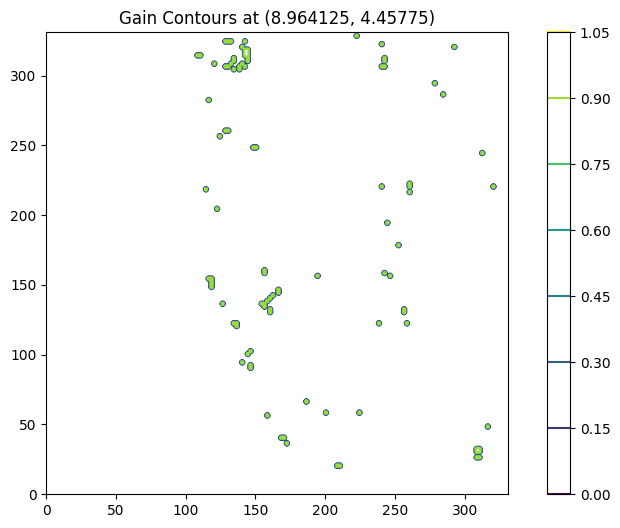

In [4]:
#data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/8.964125_4.45775_0/auxiliary/gain.npy')
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/8.9955_4.149625/auxiliary/gain.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array[0], cmap = "viridis", 
            )
plt.title("Gain Contours at (8.964125, 4.45775)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

(332, 332)


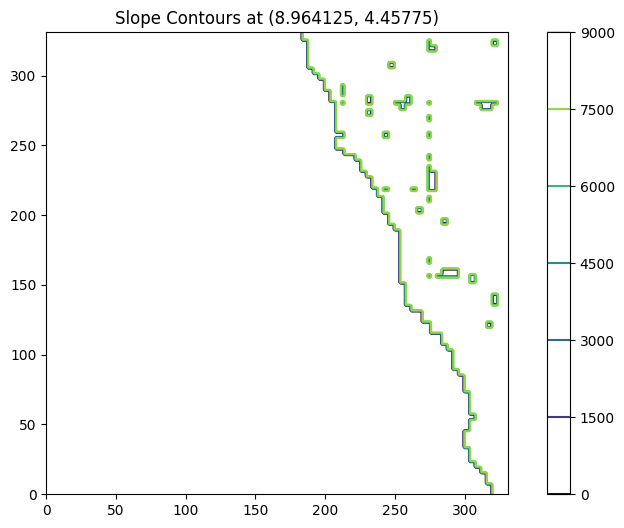

In [5]:
#data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/8.964125_4.45775_0/auxiliary/slope.npy')
data_array = np.load(f'{BASE_DIR}/{SUB_DIR}/{EXAMPLES_FOLDER}/8.9955_4.149625/auxiliary/slope.npy')
print(data_array.shape)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
plt.contour(data_array, cmap = "viridis", 
            )
plt.title("Slope Contours at (8.964125, 4.45775)")
cbar = plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

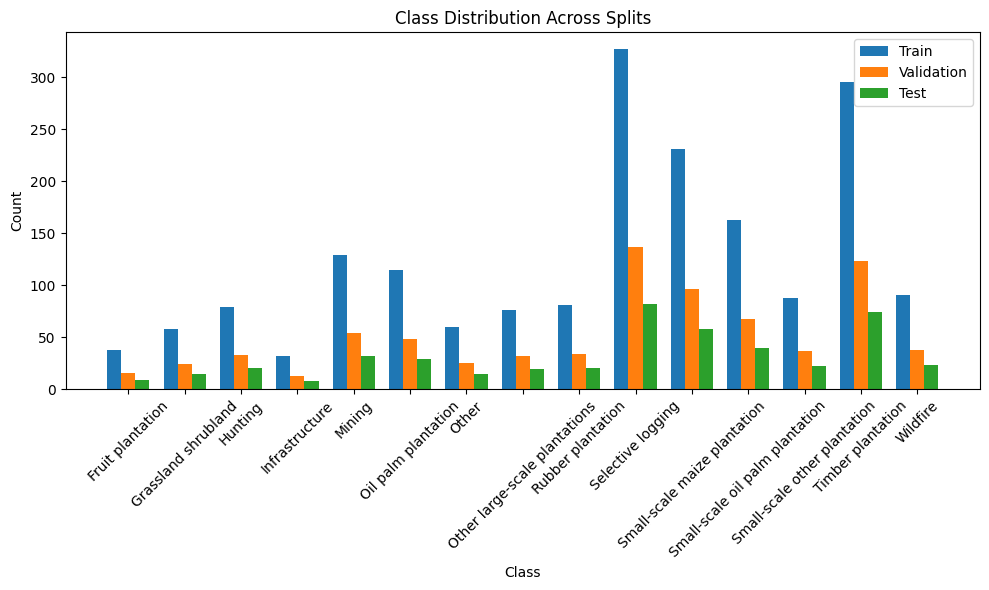

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(train, val, test):
    # Get all unique categories from all datasets
    all_categories = list(set(train['merged_label']) | 
                     set(val['merged_label']) | 
                     set(test['merged_label']))
    all_categories.sort()  # Sort alphabetically
    
    # Create positions for bars
    x = np.arange(len(all_categories))
    width = 0.25
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Function to get counts for each split
    def get_counts(df):
        counts = df['merged_label'].value_counts()
        return [counts.get(cat, 0) for cat in all_categories]
    
    # Plot bars for each split
    plt.bar(x - width, get_counts(train), width, label='Train')
    plt.bar(x, get_counts(val), width, label='Validation')
    plt.bar(x + width, get_counts(test), width, label='Test')
    
    # Add labels and formatting
    plt.xticks(x, all_categories, rotation=45)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution Across Splits')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with your actual data:
plot_class_distribution(train_df, val_df, test_df)

In [5]:
class ForestDataset(Dataset):
    """Forest dataset with unified time series support."""
    LABEL_SCHEMES = {
        'Landsat-Grouped': {
            'Grassland shrubland': 0,
            'Other': 1,
            'Plantation': 2,
            'Smallholder agriculture': 3
        },
        'Landsat-Detailed': {
            'Oil palm plantation': 0,
            'Timber plantation': 1,
            'Fruit plantation': 2,
            'Rubber plantation': 3,
            'Other large-scale plantations': 4,
            'Grassland shrubland': 5,
            'Small-scale oil palm plantation': 6,
            'Small-scale maize plantation': 7,
            'Small-scale other plantation': 8,
            'Mining': 9,
            'Selective logging': 10,
            'Infrastructure': 11,
            'Wildfire': 12,
            'Hunting': 13,
            'Other': 14
        },
        'Landsat-Detailed-Timeseries': {
            'Mining': 0,
            'Wildfire': 1,
            'Small-scale other plantation': 2,
            'Oil palm plantation': 3,
            'Small-scale oil palm plantation': 4,
            'Timber plantation': 5,
            'Rubber plantation': 6,
            'Hunting': 7,
            'Selective logging': 8,
            'Infrastructure': 9,
            'Other large-scale plantations': 10,
            'Fruit plantation': 11,
            'Small-scale maize plantation': 12,
            'Other': 13,
            'Grassland shrubland': 14
        }
    }

    def __init__(self, csv_file_to_df, root_dir='CAM-ForestNetDataset', 
                 sub_dir="Landsat-Detailed-Timeseries", transform=None, 
                 label_scheme="detailed_timeseries", types="classifier", 
                 time_steps=1):
        """
        Args:
            time_steps: Number of time steps to load (1 for single image)
        """
        self.csv = csv_file_to_df
        self.root_dir = root_dir
        self.sub_dir = sub_dir
        self.transform = transform
        self.time_steps = time_steps if time_steps else TIMESERIES_LENGTH
        self.types = types
        self.label_to_int = self.LABEL_SCHEMES[label_scheme]

    def __len__(self):
        return len(self.csv)

    def _poly_from_utm(self, polygon):
        poly_pts = []
        poly = unary_union(polygon)
        for i in np.array(poly.exterior.coords):
            poly_pts.append(tuple(i))
        return Polygon(poly_pts)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        merged_label = self.csv.iloc[idx, 1]
        lat = self.csv.iloc[idx, 2]
        long = self.csv.iloc[idx, 3]
        folder = self.csv.iloc[idx, 5]
        
        base_folder = os.path.join(self.root_dir, self.sub_dir, folder)
        
        images, segs, slopes = [], [], []
        for t in range(self.time_steps):
            png_files = glob.glob(os.path.join(base_folder, 'images/visible/*.png'))
            if not png_files:
                raise FileNotFoundError(f"No PNG files found in {base_folder}/images/visible")
            image = io.imread(png_files[0])[..., :3]
        
            slope = np.load(os.path.join(base_folder, 'auxiliary/slope.npy'))
            
            with open(f'{base_folder}/forest_loss_region.pkl', 'rb') as f:
                data = pickle.load(f)
            
            utm_zone = int((long + 180) / 6) + 1
            hemisphere = '6' if lat >= 0 else '7'
            epsg_code = int(f"32{hemisphere}{utm_zone:02d}")
            project = Transformer.from_crs("epsg:4326", f"epsg:{epsg_code}", always_xy=True).transform

            if data.geom_type == 'Polygon':
                data = [data]
            elif data.geom_type == 'MultiPolygon':
                data = list(data)

            projected_polys = [shapely_transform(project, poly) for poly in data]
            utm_x, utm_y = project(long, lat)

            half = (332 * PIXEL_RESOLUTION) / 2
            transform = from_origin(utm_x - half, utm_y + half, PIXEL_RESOLUTION, PIXEL_RESOLUTION)

            mask = rasterize(
                [(poly, 1) for poly in projected_polys],
                out_shape=(332, 332),
                transform=transform,
                fill=0,
                dtype='uint8'
            )
            seg = np.array(mask)
            
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented["image"]
            
            images.append(torch.from_numpy(image).float().permute(2,0,1)[:, 86:246, 86:246])
            segs.append(torch.from_numpy(seg).byte()[86:246, 86:246])
            slopes.append(torch.from_numpy(slope).float()[86:246, 86:246])
        
        image_series = torch.stack(images)  # (T, C, H, W)
        seg_series = torch.stack(segs)      # (T, H, W)
        slope_series = torch.stack(slopes)  # (T, H, W)
        
        merged_label = self.label_to_int[merged_label]
        
        if self.types == "classifier":
            return image_series, seg_series, slope_series, merged_label
        return image_series, seg_series, merged_label

In [6]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(270),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03
        ),
    ]
)

In [7]:
# Initialization several arguments for training
BATCH_SIZE = 16
DEVICE = device = "cuda:0" if torch.cuda.is_available() else "cpu"
EPOCHS = 20

In [8]:
train_dataset = ForestDataset( csv_file_to_df=train_df, transform=transform, root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH, label_scheme=SUB_DIR)
val_dataset = ForestDataset( csv_file_to_df=val_df, root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH, label_scheme=SUB_DIR)
test_dataset = ForestDataset( csv_file_to_df=test_df, root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH, label_scheme=SUB_DIR)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,shuffle=False)
dataloaders = {'train': trainloader, 'val':valloader}

# Load Dataset and Create DataLoader For Representation Learning
train_dataset_re = ForestDataset( csv_file_to_df=train_df, transform=transform, root_dir=BASE_DIR, sub_dir=SUB_DIR, types="projection", time_steps=TIMESERIES_LENGTH, label_scheme=SUB_DIR)
val_dataset_re = ForestDataset( csv_file_to_df=val_df, root_dir=BASE_DIR, sub_dir=SUB_DIR, types="projection", time_steps=TIMESERIES_LENGTH, label_scheme=SUB_DIR)
test_dataset_re = ForestDataset( csv_file_to_df=test_df, types="projection", root_dir=BASE_DIR, sub_dir=SUB_DIR, time_steps=TIMESERIES_LENGTH, label_scheme=SUB_DIR)
trainloader_re = torch.utils.data.DataLoader(train_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
valloader_re = torch.utils.data.DataLoader(val_dataset_re, batch_size=BATCH_SIZE,shuffle=True)
testloader_re = torch.utils.data.DataLoader(test_dataset_re, batch_size=BATCH_SIZE,shuffle=False)
dataloaders_re = {'train': trainloader_re, 'val':valloader_re}

images shape on PyTorch :  torch.Size([16, 1, 3, 160, 160])
seg shape on PyTorch :  torch.Size([16, 1, 160, 160])
slope shape on PyTorch :  torch.Size([16, 1, 160, 160])
labels shape on Pytorch :  torch.Size([16])


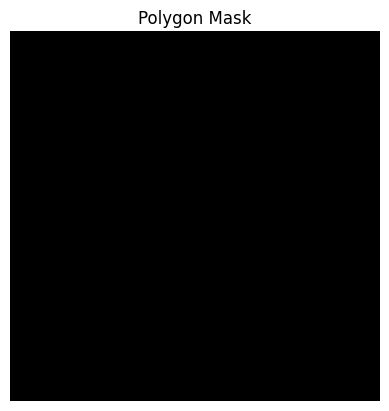

In [9]:
dataiter = iter(trainloader)
images, seg, slope, labels = next(dataiter)

print('images shape on PyTorch : ', images.size())
print('seg shape on PyTorch : ', seg.size())
print('slope shape on PyTorch : ', slope.size())
print('labels shape on Pytorch : ', labels.size())

plt.imshow(seg[0][0].numpy(), cmap='gray')
plt.title("Polygon Mask")
plt.axis('off')
plt.show()

In [10]:
sample = next(iter(trainloader_re))[1]
print(sample.shape)

sample_target = next(iter(valloader_re))[1]
print(sample_target.shape)

torch.Size([16, 1, 160, 160])
torch.Size([16, 1, 160, 160])


In [11]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

In [12]:
dataset_sizes = {'train':len(train_df), 'val':len(val_df)}
acc_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}
NB_CLASSES = len(train_dataset.label_to_int)

In [13]:
criterion_class = FocalLoss()
criterion_seg = DiceLoss()

In [14]:
"""Training UNet Classifier + Segmentation"""

unet_model = UNet(3,NB_CLASSES,"classification")
unet_model = unet_model.to(device)

optimizer = torch.optim.AdamW(unet_model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
acc_seg_dict = {'train':[], 'val':[]}
acc_class_dict = {'train':[], 'val':[]}
loss_dict= {'train':[], 'val':[]}

In [15]:
def train_model(model, optimizer, scheduler, dataloaders, criterion_seg, criterion_class,
                acc_seg_dict, acc_class_dict, loss_dict, device,
                num_epochs=25, patience=5,save_dir='model_weights', resume=False):
    
    os.makedirs(save_dir, exist_ok=True)

    def get_dynamic_filename(epoch=None, acc=None, suffix="pth"):
        date_str = datetime.now().strftime("%Y%m%d")
        name_parts = [str(x) for x in [MODEL_NAME, SUB_DIR]]
        if epoch is not None:
            name_parts.append(f"epoch{epoch}")
        if acc is not None:
            name_parts.append(f"acc{acc:.4f}")
        name_parts.append(date_str)
        return os.path.join(save_dir, "_".join(name_parts) + f".{suffix}")

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_without_improvement = 0
    start_epoch = 0

    checkpoint_path = get_dynamic_filename(suffix="checkpoint")

    # Resume if enabled
    if resume and os.path.exists(checkpoint_path):
        checkpoint = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
        best_acc = checkpoint['best_acc']
        start_epoch = checkpoint['epoch'] + 1
        epochs_without_improvement = checkpoint.get('epochs_without_improvement', 0)
        best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_acc_seg = 0.0
            running_acc_class = 0.0

            for images, seg, slope, labels in dataloaders[phase]:
                if images.ndim == 5 and images.shape[1] == 1:
                    images = images.squeeze(1)
                if seg.ndim == 4 and seg.shape[1] > 1:
                    seg = seg.unsqueeze(2)

                images, seg, slope, labels = images.to(device), seg.to(device), slope.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, out_class = model(images, slope)
                    loss_seg = criterion_seg(outputs, seg.float())
                    loss_class = criterion_class(out_class, labels)
                    loss = loss_seg + loss_class

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                m1, m0, m_avg = get_acc_binseg(outputs, seg.float())
                running_acc_seg += m_avg
                running_acc_class += get_acc_class(out_class, labels).item()
                running_loss += loss.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc_seg = running_acc_seg / len(dataloaders[phase])
            epoch_acc_class = running_acc_class / len(dataloaders[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc Seg: {epoch_acc_seg:.4f} Acc Class: {epoch_acc_class:.4f}')
            acc_seg_dict[phase].append(epoch_acc_seg)
            acc_class_dict[phase].append(epoch_acc_class)
            loss_dict[phase].append(epoch_loss)

            # Save checkpoint if best
            if phase == 'val':
                if epoch_acc_class > best_acc:
                    best_acc = epoch_acc_class
                    best_model_wts = copy.deepcopy(model.state_dict())
                    save_checkpoint({
                        'epoch': epoch,
                        'model_state_dict': best_model_wts,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                        'epochs_without_improvement': 0,
                    }, checkpoint_path)
                    epochs_without_improvement = 0
                    print(f"New best model saved at epoch {epoch+1}")
                else:
                    epochs_without_improvement += 1
                    print(f"No improvement. Patience counter: {epochs_without_improvement}/{patience}")

                if epochs_without_improvement >= patience:
                    print("Early stopping triggered.")
                    model.load_state_dict(best_model_wts)
                    final_path = get_dynamic_filename(epoch=epoch, acc=best_acc)
                    torch.save(model.state_dict(), final_path)
                    print(f"Final model saved to {final_path}")
                    return model

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    final_path = get_dynamic_filename(epoch=num_epochs, acc=best_acc)
    torch.save(model.state_dict(), final_path)
    print(f"Final model saved to {final_path}")
    return model

In [16]:
unet_classifier_segmentation = train_model(
    unet_model,
    optimizer,
    scheduler,
    num_epochs=EPOCHS,
    dataloaders=dataloaders,
    criterion_seg=criterion_seg,
    criterion_class=criterion_class,
    acc_class_dict=acc_class_dict,
    acc_seg_dict=acc_seg_dict,
    loss_dict=loss_dict,
    device="cpu"
)


Epoch 1/20
----------
train Loss: 2.3634 Acc Seg: 0.5098 Acc Class: 0.3419
val Loss: 2.3763 Acc Seg: 0.5270 Acc Class: 0.2791
Checkpoint saved to model_weights/UNet_Landsat-Detailed_20250612.checkpoint
New best model saved at epoch 1

Epoch 2/20
----------
train Loss: 1.9210 Acc Seg: 0.5243 Acc Class: 0.4487
val Loss: 2.6948 Acc Seg: 0.5042 Acc Class: 0.2148
No improvement. Patience counter: 1/5

Epoch 3/20
----------
train Loss: 1.5534 Acc Seg: 0.5049 Acc Class: 0.5946
val Loss: 2.8402 Acc Seg: 0.5026 Acc Class: 0.2495
No improvement. Patience counter: 2/5

Epoch 4/20
----------
train Loss: 1.2941 Acc Seg: 0.5188 Acc Class: 0.7126
val Loss: 2.6672 Acc Seg: 0.5282 Acc Class: 0.2980
Checkpoint saved to model_weights/UNet_Landsat-Detailed_20250612.checkpoint
New best model saved at epoch 4

Epoch 5/20
----------
train Loss: 1.1648 Acc Seg: 0.5217 Acc Class: 0.7783
val Loss: 2.9274 Acc Seg: 0.5240 Acc Class: 0.2416
No improvement. Patience counter: 1/5

Epoch 6/20
----------
train Loss: 

In [17]:
def show_curves(acc_dict, loss_dict):
    fig = plt.figure(figsize=(22,8))
    train_score,eval_score = acc_dict.values()
    train_score=list(map(float,train_score))
    eval_score=list(map(float,eval_score))
    ax = plt.figure().gca()
    plt.plot(train_score)
    plt.plot(eval_score)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Accuracy')
    plt.title('Learning curves')
    plt.show()
    
    train_loss, eval_loss = loss_dict.values()
    train_loss=list(map(float,train_loss))
    eval_loss=list(map(float,eval_loss))
    ax = plt.figure().gca()
    plt.plot(train_loss)
    plt.plot(eval_loss)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.legend(['train', 'val'])
    plt.xlabel('number of epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.show()

<Figure size 2200x800 with 0 Axes>

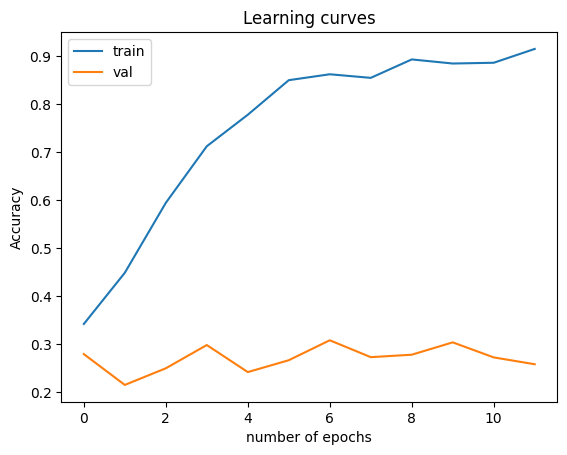

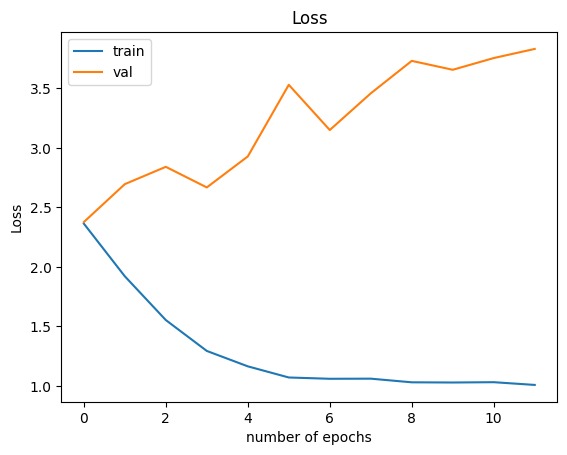

In [18]:
show_curves(acc_class_dict, loss_dict)

<Figure size 2200x800 with 0 Axes>

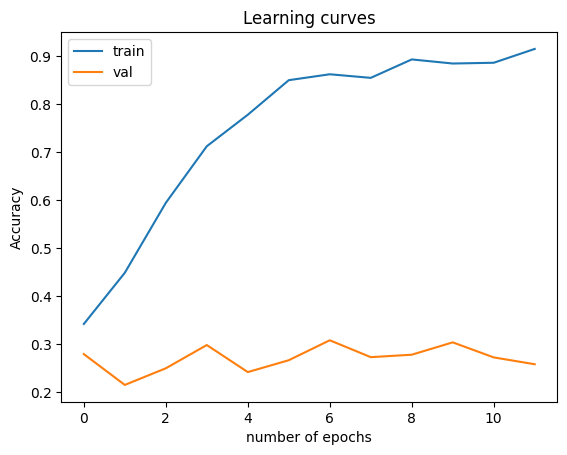

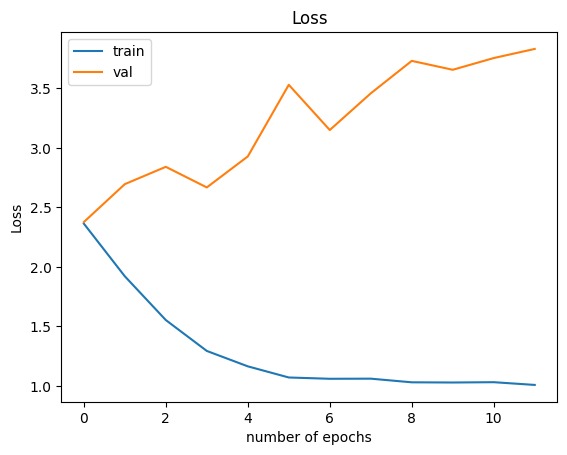

In [19]:
show_curves(acc_class_dict, loss_dict)

In [25]:
def test(model, dataloader, dataset):
    model.eval()

    all_preds = []
    all_labels = []
    class_names = [label for label, _ in sorted(dataset.label_to_int.items(), key=lambda x: x[1])]

    running_accuracy = 0 
    total = 0 
 
    with torch.no_grad(): 
        for images, seg, slope, labels in dataloader: 
            if images.ndim == 5 and images.shape[1] == 1:
                images = images.squeeze(1)
            if seg.ndim == 4 and seg.shape[1] > 1:
                seg = seg.unsqueeze(2)
                
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            labels = labels.to(device)

            outputs, out_class = model(images, slope)

            total += labels.size(0) 
            running_accuracy += get_acc_class(out_class, labels).item()
            preds = torch.argmax(out_class, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) 
 
        print('Accuracy of the model based on the test set is: %d %%' % (100 * running_accuracy / len(testloader))) 

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("\nConfusion Matrix:")
    print(confusion_matrix(all_labels, all_preds))
 

In [26]:
test(unet_classifier_segmentation, testloader, test_dataset)

Accuracy of the model based on the test set is: 27 %

Classification Report:
                                 precision    recall  f1-score   support

            Oil palm plantation       0.13      0.07      0.09        29
              Timber plantation       0.34      0.46      0.39        74
               Fruit plantation       0.00      0.00      0.00         9
              Rubber plantation       0.00      0.00      0.00        20
  Other large-scale plantations       0.00      0.00      0.00        19
            Grassland shrubland       0.00      0.00      0.00        15
Small-scale oil palm plantation       0.24      0.25      0.25        40
   Small-scale maize plantation       0.94      0.50      0.65        58
   Small-scale other plantation       0.17      0.05      0.07        22
                         Mining       0.08      0.03      0.04        32
              Selective logging       0.23      0.63      0.33        82
                 Infrastructure       0.00    

In [29]:
def plot_prediction_comparison(model, dataloader, num_examples=3):
    model.eval()
    fig, axes = plt.subplots(num_examples, 4, figsize=(20, 5*num_examples))
    
    with torch.no_grad():
        for i, (images, seg, slope, labels) in enumerate(dataloader):
            if i >= num_examples:
                break

            # Handle input dimensions
            if images.ndim == 5 and images.shape[1] == 1:
                images = images.squeeze(1)
                
            images = images.to(device)
            seg = seg.to(device)
            slope = slope.to(device)
            
            # Get predictions
            outputs, out_class = model(images, slope)
            pred_masks = (torch.sigmoid(outputs) > 0.5).float()
            pred_class = torch.argmax(out_class, dim=1)
            true_class = labels[i]
            
            # Process image for display
            img_np = images[0].cpu().permute(1,2,0).numpy()
            img_np = img_np.astype(np.float32)
            for c in range(3):
                channel = img_np[:, :, c]
                img_np[:, :, c] = (channel - channel.min()) / (channel.max() - channel.min() + 1e-5)

            # Process masks - fix reshaping here
            true_mask = seg[0].cpu().squeeze().numpy()  # Remove channel dim if present
            pred_mask = pred_masks[0].cpu().squeeze().numpy()
            
            # Calculate IoU
            iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), average='binary')
            
            # Plotting
            axes[i,0].imshow(img_np)
            axes[i,0].set_title('Input Image')
            axes[i,0].axis('off')
            
            axes[i,1].imshow(true_mask, cmap='gray')
            axes[i,1].set_title(f'Ground Truth\nClass: {labels[0].item()}')
            axes[i,1].axis('off')
            
            axes[i,2].imshow(pred_mask, cmap='gray')
            axes[i,2].set_title(f'Predicted Mask\nIoU: {iou:.3f}')
            axes[i,2].axis('off')
            
            # Class probabilities
            class_probs = torch.softmax(out_class[0], dim=0).cpu().numpy()
            num_classes = class_probs.shape[0]
            axes[i,3].bar(range(num_classes), class_probs)
            pred_class = torch.argmax(out_class[0]).item()
            axes[i,3].set_title(f'Class Probabilities\nPred: {pred_class} True: {true_class}')
            axes[i,3].set_ylim(0, 1)
            axes[i,3].set_xticks(range(num_classes))
    
    plt.tight_layout()
    plt.show()

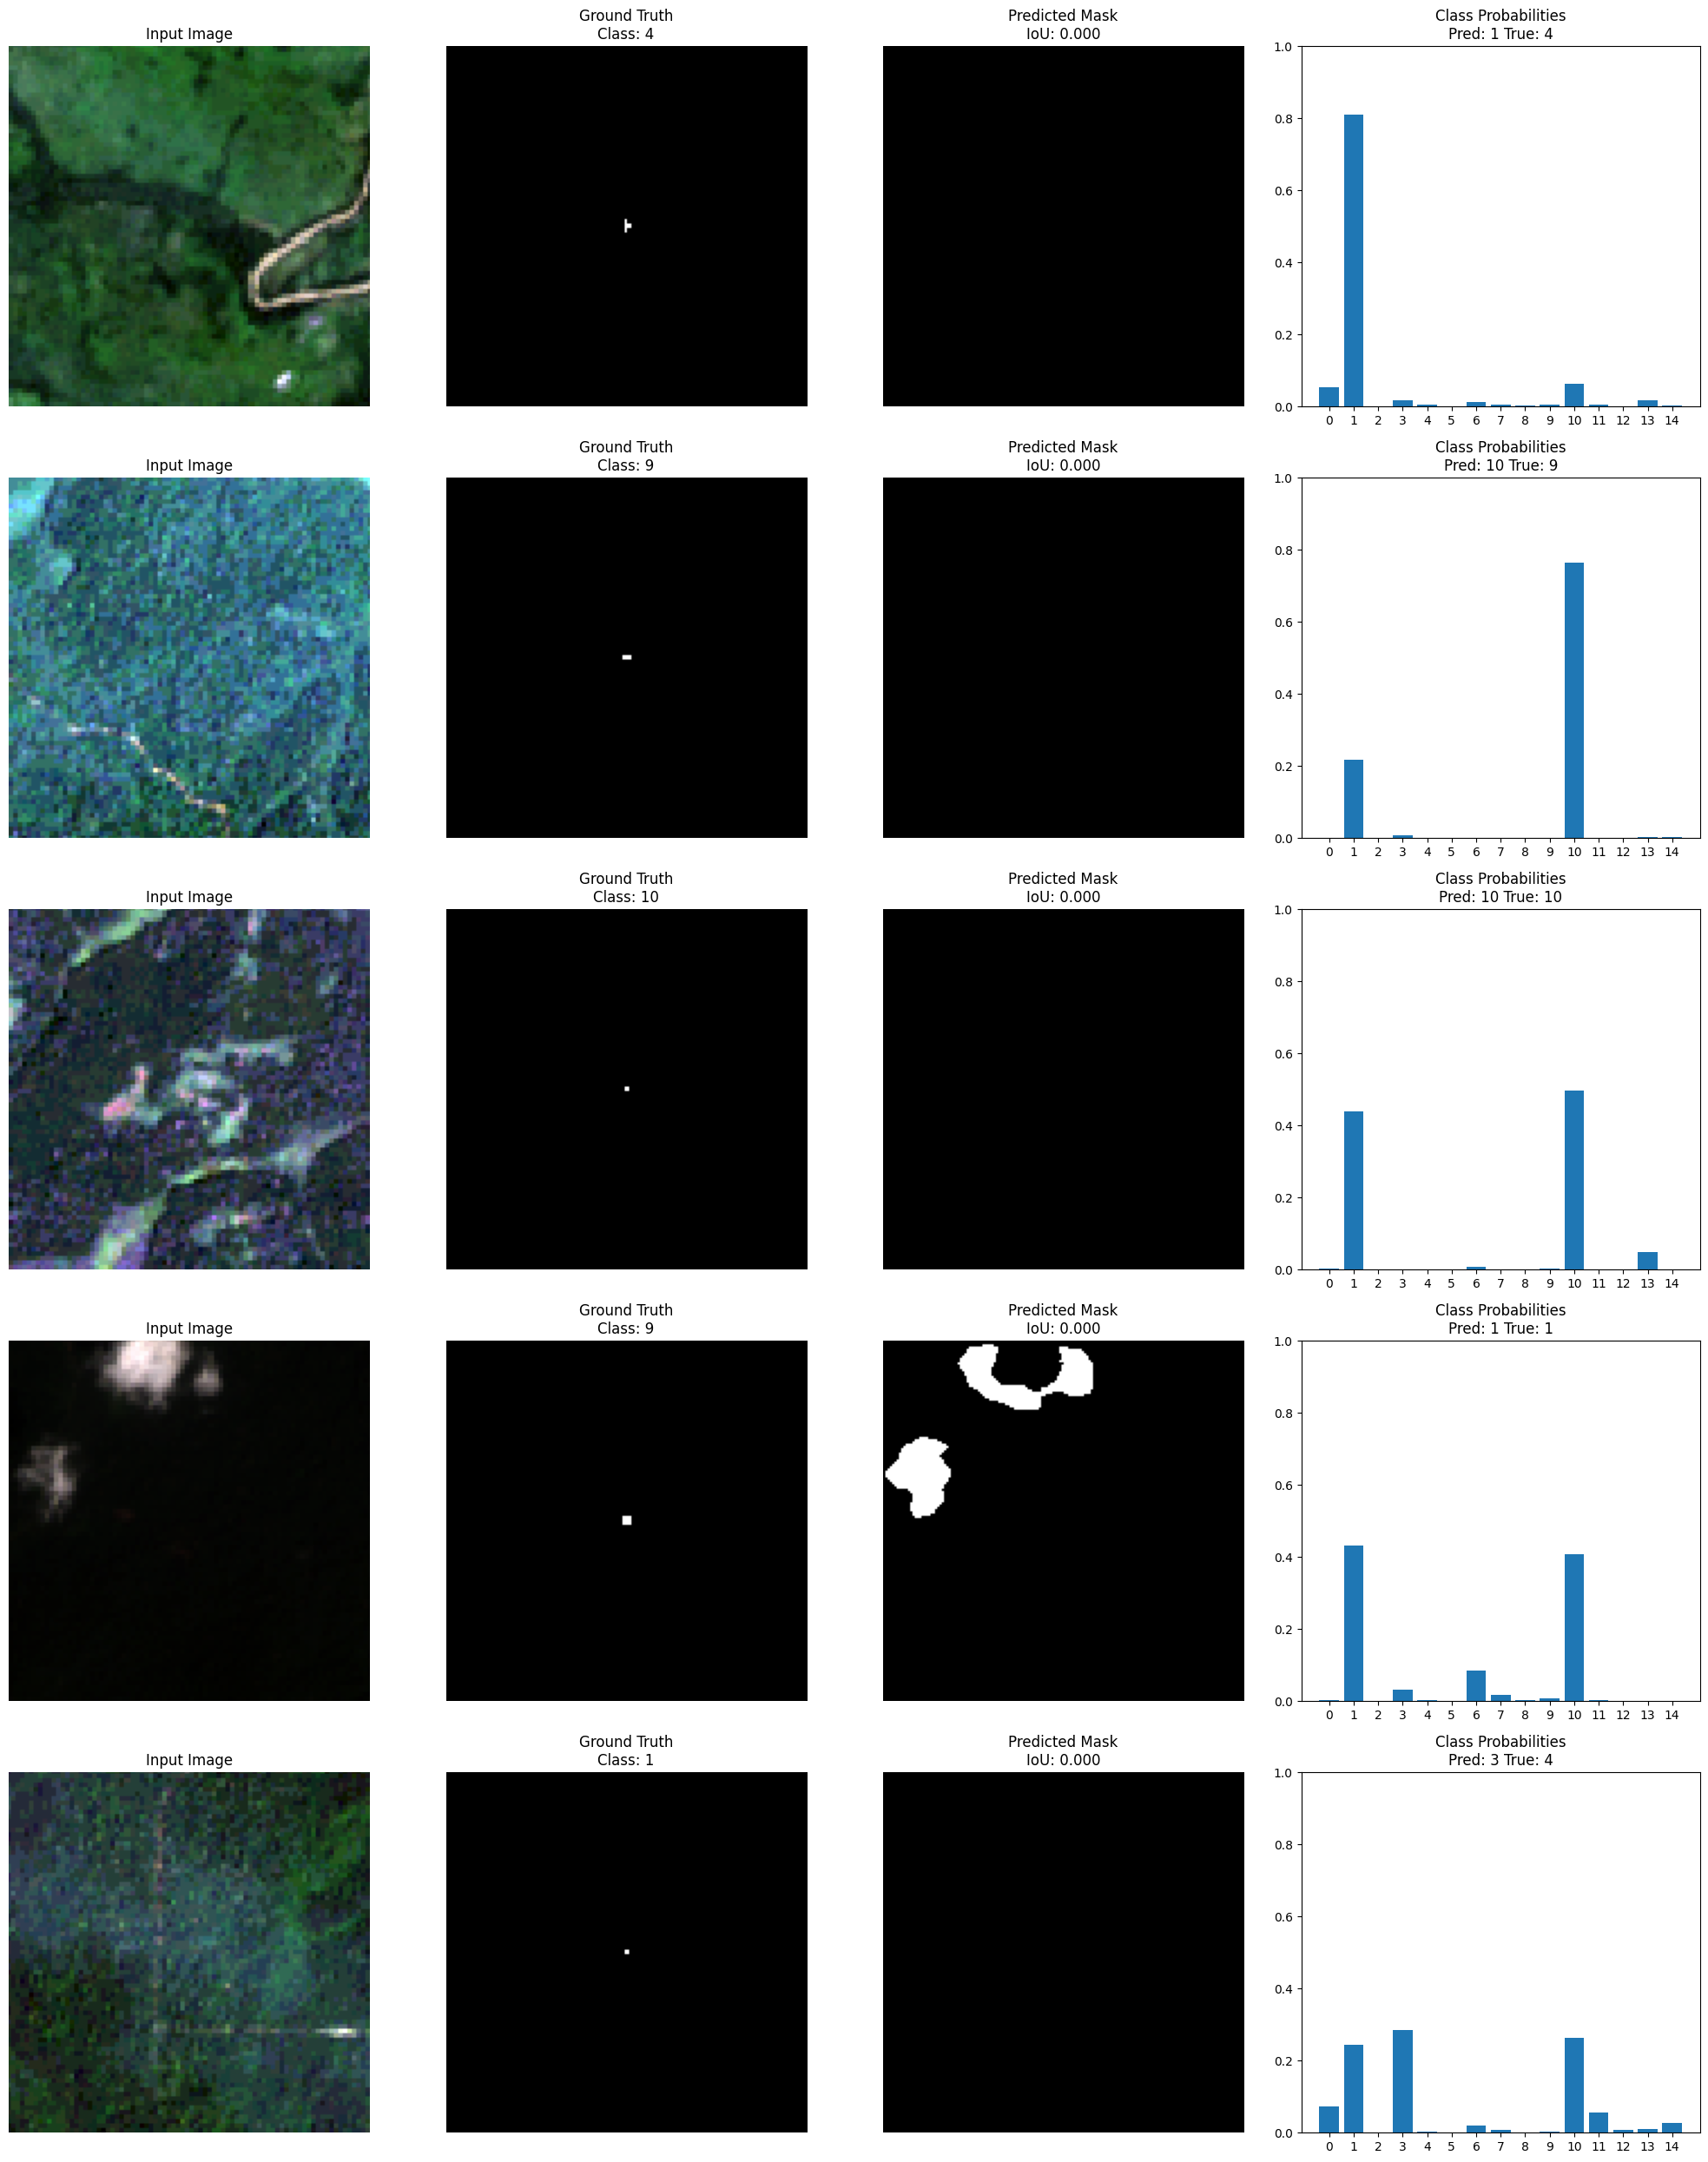

In [30]:
plot_prediction_comparison(unet_classifier_segmentation, testloader, num_examples=5)